In [2]:
from cleaning import clean_data, SMOTE_resample
import numpy as np
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression, SelectPercentile, mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from collections import Counter
from evaluate import qwk
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import BaggingClassifier

In [3]:
# Load Data
X_train, y_train, X_test, y_test = clean_data('')
# print(Counter(y_train))

# SMOTE resampling
X_train, y_train = SMOTE_resample(X_train, y_train)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# print(X_train.shape)
# print(X_val.shape)
# print(y_train.shape)
# print(y_val.shape)
# print(Counter(y_train))
# # Feature selection
# pca = PCA(svd_solver='full')
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

In [7]:
# PCA Decomposition
pca = PCA(svd_solver='full')
pcaX_train = pca.fit_transform(X_train)
pcaX_test = pca.transform(X_test)

# Select Percentile
sp = SelectPercentile(mutual_info_classif)
spX_train = sp.fit_transform(X_train, y_train)
spX_test = sp.transform(X_test)

# Variance Threshold
vt = VarianceThreshold(threshold=(.8 * (1 - .8)))
vtX_train = vt.fit_transform(X_train, y_train)
vtX_test = vt.transform(X_test)

In [9]:
losses = ["hinge", "squared_hinge"]
learning_rates = [1e-3, 1e-2, 1e-1, 1, 10]
penalties = ["l1", "l2"]

random_grid = {
    "C": learning_rates,
    "penalty": penalties,
    "loss": losses,
}

svc = LinearSVC(dual=False)
svc_random = RandomizedSearchCV(estimator=svc, param_distributions=random_grid, n_iter=10, cv=3, verbose=0, n_jobs=-1, error_score=np.NINF)
svc_random.fit(pcaX_train, y_train)
print(f'Best Parameters = {svc_random.best_params_}')
print(f'Best Score = {svc_random.best_score_}')

c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-pac

Best Parameters = {'penalty': 'l1', 'loss': 'squared_hinge', 'C': 10}
Best Score = 0.3659070707535444


c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
# Linear SVC
best_params = {'penalty': 'l1', 'loss': 'squared_hinge', 'C': 1}
# best_params = svc_random.best_params_
lsvc = LinearSVC(dual=False, penalty=best_params['penalty'], loss=best_params['loss'], C=best_params['C'])
lsvc.fit(pcaX_train, y_train)
y_pred = lsvc.predict(pcaX_test)
print(f'Train Score = {lsvc.score(pcaX_train, y_train)}')
print(f'Test Score = {lsvc.score(pcaX_test, y_test)}')
print(f'QWK = {qwk(y_test, y_pred)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.396189179993195
Test Score = 0.2883503779457537
QWK = 0.999999962013711
Cohens Kappa Score = 0.23146124839879578


c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


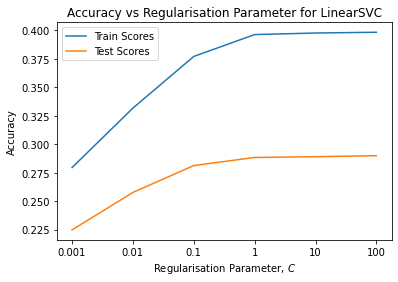

In [11]:
# Regularisation Parameter
regParam = [1e-3, 1e-2, 1e-1, 1, 10, 100]

trainScores = []
testScores = []
for C in regParam:
    lsvc = LinearSVC(dual=False, penalty='l1', loss='squared_hinge', C=C)
    lsvc.fit(pcaX_train, y_train)
    trainScores.append(lsvc.score(pcaX_train, y_train))
    testScores.append(lsvc.score(pcaX_test, y_test))
regNames = [str(x) for x in regParam]

plt.plot(regNames, trainScores, label='Train Scores')
plt.plot(regNames, testScores, label='Test Scores')
plt.title(f'Accuracy vs Regularisation Parameter for LinearSVC')
plt.xlabel('Regularisation Parameter, $C$')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [14]:
# SVC
learning_rates = [1e-3, 1e-2, 1e-1, 1, 10, 100]
gammas = ['scale', 'auto']

param_grid = {
    "C": learning_rates,
    "gamma": gammas,
}

svc = SVC(kernel='rbf')
svc_grid = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1, error_score=np.NINF)
svc_grid.fit(X_train, y_train)
print(f'Best Parameters = {svc_grid.best_params_}')
print(f'Best Score = {svc_grid.best_score_}')
# 0.5311323225032968

Best Parameters = {'C': 100, 'gamma': 'scale'}
Best Score = 0.5637972099353521


In [15]:
# SVC
best_params = {'C': 100, 'gamma': 'scale'}
# best_params = svc_random.best_params_
svc = SVC(kernel='rbf', gamma=best_params['gamma'], C=best_params['C'])
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f'Train Score = {svc.score(X_train, y_train)}')
print(f'Test Score = {svc.score(X_test, y_test)}')
print(f'QWK = {qwk(y_test, y_pred)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.921537938074175
Test Score = 0.34104046242774566
QWK = 0.9999999613877356
Cohens Kappa Score = 0.2187965119056956


In [17]:
# Bagging Classifier
bc = BaggingClassifier(base_estimator=svc, n_estimators=10, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print(f'Train Score = {bc.score(X_train, y_train)}')
print(f'Test Score = {bc.score(X_test, y_test)}')
print(f'QWK = {qwk(y_test, y_pred)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.4029431779516843
Test Score = 0.2979101823032459
QWK = 0.9999999603229333
Cohens Kappa Score = 0.19725342728998174


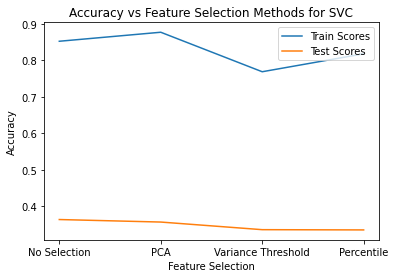

In [5]:
# Feature Selection
dataLabels = ['No Selection', 'PCA', 'Variance Threshold', 'Percentile']
data = [(X_train, X_test), (pcaX_train, pcaX_test), (vtX_train, vtX_test), (spX_train, spX_test)]

trainScores = []
testScores = []
for i, label in enumerate(dataLabels):
    xtrain, xtest = data[i]
    svc = SVC(kernel='rbf', gamma='scale', C=20)
    svc.fit(xtrain, y_train)
    trainScores.append(svc.score(xtrain, y_train))
    testScores.append(svc.score(xtest, y_test))

plt.plot(dataLabels, trainScores, label='Train Scores')
plt.plot(dataLabels, testScores, label='Test Scores')
plt.title(f'Accuracy vs Feature Selection Methods for SVC')
plt.xlabel('Feature Selection')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

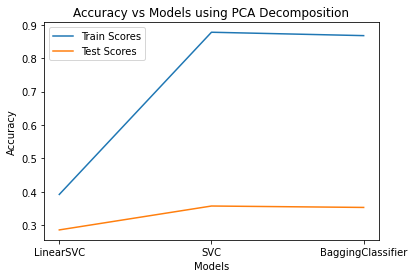

In [5]:
# Retrain models
models = [
    LinearSVC(penalty='l1', max_iter=5000, loss='squared_hinge', dual=False, C=1),
    SVC(kernel='rbf', gamma='scale', C=20),
    BaggingClassifier(base_estimator=SVC(kernel='rbf', gamma='scale', C=20), n_estimators=10, n_jobs=-1)
]
names = ['LinearSVC', 'SVC', 'BaggingClassifier']
trainScores = []
testScores = []
for model in models:
    model.fit(pcaX_train, y_train)
    trainScores.append(model.score(pcaX_train, y_train))
    testScores.append(model.score(pcaX_test, y_test))

plt.plot(names, trainScores, label='Train Scores')
plt.plot(names, testScores, label='Test Scores')
plt.title(f'Accuracy vs Models using PCA Decomposition')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

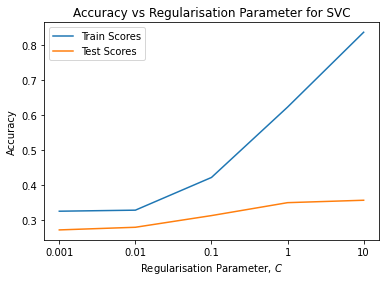

In [6]:
# Regularisation Parameter
regParam = [1e-3, 1e-2, 1e-1, 1, 10]

trainScores = []
testScores = []
for C in regParam:
    svc = SVC(kernel='rbf', gamma='scale', C=C)
    svc.fit(pcaX_train, y_train)
    trainScores.append(svc.score(pcaX_train, y_train))
    testScores.append(svc.score(pcaX_test, y_test))
regNames = [str(x) for x in regParam]

plt.plot(regNames, trainScores, label='Train Scores')
plt.plot(regNames, testScores, label='Test Scores')
plt.title(f'Accuracy vs Regularisation Parameter for SVC')
plt.xlabel('Regularisation Parameter, $C$')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()